In [1]:
import xarray
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from skimage.restoration import denoise_bilateral, denoise_wavelet
# import Py6S

from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern

In [2]:
aerial_F = xarray.open_dataset('data/SSC_SENSECOWG1/1_SSC_data/Airborne_F.nc')
aerial_HSI = xarray.open_dataset('data/SSC_SENSECOWG1/1_SSC_data/Airborne_HDRF.nc')
aerial_LST = xarray.open_dataset('data/SSC_SENSECOWG1/1_SSC_data/Airborne_LST.nc')
field_data = pd.read_csv('data/SSC_SENSECOWG1/1_SSC_data/FieldData.csv')

In [3]:
def stack(x):
    return np.atleast_2d(x.stack(pix=['row','col']).copy().values)

def preprocess_hsi(x, data_var='var_',
                   geometry_vars=[]):
    xnew=[]
    xnew.append(stack(x[data_var]))
    for v in geometry_vars:
        xnew.append(stack(x[v]))
    return np.concatenate(xnew).T

def to_xarray(x, shape=(100,100,5)):
    return xarray.DataArray(x.reshape(shape).T,
                         dims=['dim0','col','row'])

def get_pix_n(xs, ys):
    lookup = np.arange(10000).reshape((100,100))
    return lookup[ys, xs]

def get_window_n(xs, ys, k=[-1,0,1]):
    """same as get_pix_n but retrieves a windowed region around point
    """
    out = []
    for i in k:
        for j in k:
            out.append(get_pix_n(xs+i, ys+j))
    return np.concatenate(out)

# LAI
- Decompose HSI to a lower dimensional subspace
- fit a Gaussian Process Regressor to the reprojected HSI

## PCA N_components estimation


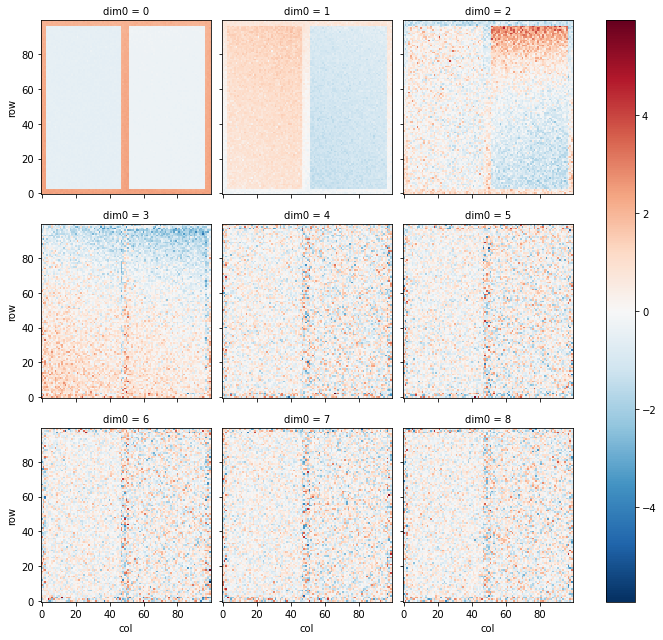

In [4]:
PCs = to_xarray(PCA(n_components=9).fit_transform(
    stack(aerial_HSI['var_']).T), (100,100,9))

# scale each PC to 0 mean and var 1
((PCs - PCs.mean(['row','col'])) / PCs.std(['row','col'])
).T.plot(col='dim0', col_wrap=3)

Looks like only the first 4 principal components contain information and the others are dominated by noise (the slight plot effect in higher order PCs is probably because the noise is Poisson for image data, so increased variance with signal).

We can just use the first 4 PCs which should account for plot v. non plot, different plots and within plot gradients

Text(0.5, 1.0, 'LAI')

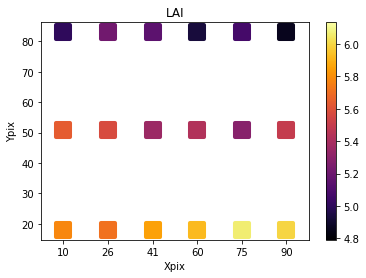

In [5]:
cvar = 'LAI'
ax = seaborn.pointplot(data=field_data, x='Xpix', y='Ypix',
                       hue=cvar, palette='inferno', markers='s',scale=2)

norm = plt.Normalize(field_data[cvar].min(), field_data[cvar].max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm)
ax.set_title(cvar)

In [6]:
N_COMPONENTS = 4

# Preprocess the array data
s_1 = preprocess_hsi(aerial_HSI)
spectral_decomposer = PCA(n_components=N_COMPONENTS)

# Do a PCA decomposition
pca_1 = spectral_decomposer.fit_transform(s_1)

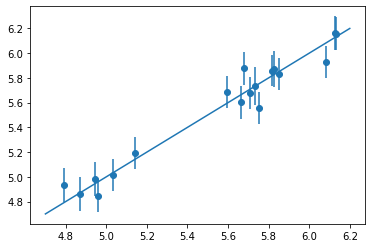

In [7]:
# get the PC features and labels from field data
X = pca_1[get_window_n(field_data['Xpix'], field_data['Ypix'], [-1,0,1]),...]
y = np.tile(field_data['LAI'].values, 9)

# Specify Gaussian Kernel
kernel = ConstantKernel(1) + \
Matern(length_scale=np.ones(N_COMPONENTS), nu=5/2, length_scale_bounds=[1e-4,1e4]) + \
WhiteKernel(noise_level=1) 
GPR_LA = GaussianProcessRegressor(kernel=kernel, copy_X_train=True)

# Fit the GPR
GPR_LA.fit(X, y)

_X = pca_1[get_pix_n(field_data['Xpix'], field_data['Ypix']), :]
_y = field_data['LAI']
plt.scatter(_y,GPR_LA.predict(_X))
plt.errorbar(_y,GPR_LA.predict(_X),GPR_LA.predict(_X, return_std=True)[1],fmt='none')
plt.plot(np.linspace(4.7, 6.2),np.linspace(4.7, 6.2))

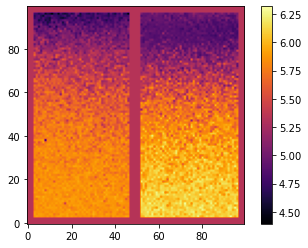

In [8]:
prediction_LA, SE_LA = GPR_LA.predict(pca_1, return_std=True)
plt.imshow(prediction_LA.reshape((100,100)),
           origin='lower', cmap='inferno')
plt.colorbar()

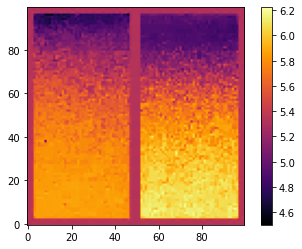

In [9]:
plt.imshow(denoise_wavelet(prediction_LA.reshape((100,100))),
           origin='lower', cmap='inferno')
plt.colorbar()

# Chlorophyll concentration

Text(0.5, 1.0, 'Cab')

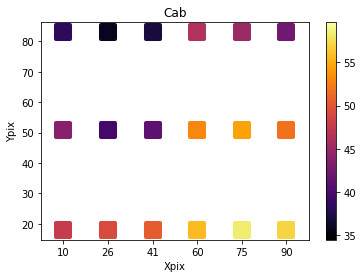

In [10]:
cvar = 'Cab'
ax = seaborn.pointplot(data=field_data, x='Xpix', y='Ypix',
                       hue=cvar, palette='inferno', markers='s',scale=2)

norm = plt.Normalize(field_data[cvar].min(), field_data[cvar].max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm)
ax.set_title(cvar)

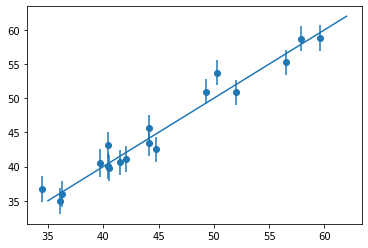

In [11]:
# get the PC features and labels from field data
y2 = np.tile(field_data['Cab'].values, 9)

# Specify Gaussian Kernel
kernel = ConstantKernel(1) + \
Matern(length_scale=np.ones(N_COMPONENTS), nu=5/2) + \
WhiteKernel(noise_level=1)

GPR_cab = GaussianProcessRegressor(kernel=kernel)

# Fit the GPR
GPR_cab.fit(X, y2/10)

_X = pca_1[get_pix_n(field_data['Xpix'], field_data['Ypix']), :]
_y = field_data['Cab']
plt.scatter(_y,GPR_cab.predict(_X) * 10)
plt.errorbar(_y,GPR_cab.predict(_X) * 10,GPR_cab.predict(_X, return_std=True)[1] * 10,fmt='none')
plt.plot(np.linspace(35,62),np.linspace(35,62))

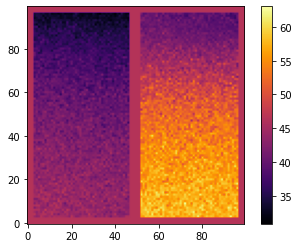

In [12]:
prediction_cab, SE_cab = GPR_cab.predict(pca_1, return_std=True)
plt.imshow(prediction_cab.reshape((100,100)) * 10,
           origin='lower', cmap='inferno')
plt.colorbar()